<a id='Top'></a>
<center>
    <h1><u><b>Implementing Real Time Clustering Problems With Raw Dataset</b></u></h1>
</center>

---

This project shows how to perform a mall customers segmentation using Machine Learning algorithms. This is the unsupervised clustering problem with two  popular algorithms will be presented and compared: KMeans, and DBSCAN. The main aim of this notebook is to cover the basics of clustering methods.

---
<a id='Intro'></a>
## 1. Introduction  <a href='#Top' style="text-decoration: none;">^</a><br>


The main task of clustering is to discover „natural“ groups within an unlabelled dataset - this means that's an unsuprvised ML task. And it's an important one, as as it is used in many scientific, engineering and business domains. One of the most known application of clustering are:  
* customers segmentation (for efficient marketing)
* image segmentation 
* documents clusterisation.
  
---
There is a vast number of clustering algorithms and currently, there is no single one that dominates other ones. Choosing the best one depends on the database itself, an application domain and client requirements and expectations.

This notebook focuses on two partitional algorithms: K-Means, and DBSCAN. All are implemented in a well-known Python library: Scikit-Learn.

<a id='Reading_data'></a>
## 2. Reading data <a href='#Top' style="text-decoration: none;">^</a><br>

In this section, raw data will be read, overviewed and checked if any cleaning is required.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 2.0.3
numpy version: 1.21.5
seaborn version: 0.12.2


In [3]:
mall_data = pd.read_csv('Mall_Customers.csv')
mall_data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
mall_data.shape

(200, 5)

In [3]:
mall_data.sample(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
96,97,Female,47,60,47
40,41,Female,65,38,35
195,196,Female,35,120,79
160,161,Female,56,79,35
56,57,Female,51,44,50
36,37,Female,42,34,17
86,87,Female,55,57,58
33,34,Male,18,33,92
46,47,Female,50,40,55
155,156,Female,27,78,89


In [5]:
mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


There are 5 columns:
* `Customer ID` - numerical - unique customer number - integer
* `Gender` - categorical - binary (Male/Female)
* `Age` - numerical - integer
* `Annual Income (k$)` - numerical - integer
* `Spending Score (1-100)` - numerical - integer

In [7]:
mall_data.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

There are no missing data. This simplifies the analysis but it is a very unlikely scenario in a real-life where analysts spend a significant amount of time cleaning their data before the core analysis is performed

In [8]:
import warnings
warnings.filterwarnings('ignore')

<a id='Exploratory_Data_Analysis'></a>
## 3. Exploratory Data Analysis<a href='#Top' style="text-decoration: none;">^</a><br>

This section contains a basic statistical investigation of a given database. It is a crucial point in any analysis as it allows for a better understanding of the underlying data. This part has one main section: distributions.

<a id='Distributions'></a>
### 3.1 Distributions <a href='#Top' style="text-decoration: none;">^</a><br>

In this chapter distributions of numerical variables will be investigated in detail. Data will be stratified by gender - the only categorical variable.

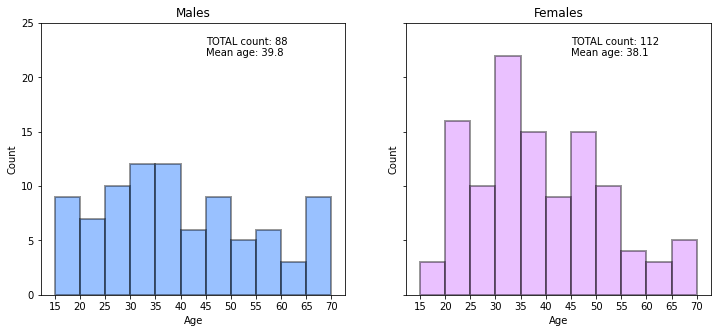

In [9]:
males_age = mall_data[mall_data['Genre']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Genre']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

The average age of male customers is lightly higher than female ones (39.8 versus 38.1). Distribution of male age is more uniform than females, where we can observe that the biggest age group is 30-35 years old.

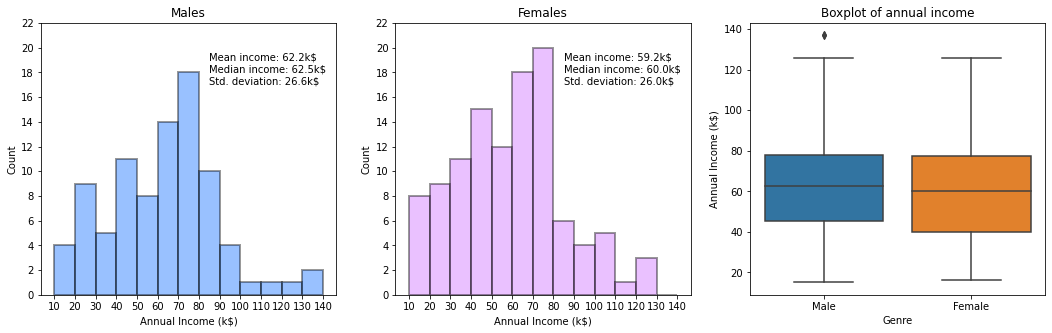

In [11]:
males_income = mall_data[mall_data['Genre']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Genre']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Genre', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

Mean income of males is higher than females (62.2 k\\$ vs. 59.2k\\$). Also median income of male customers (62.5k\\$) is higher thn female ones (60k\\$). Standard deviation is similar for both groups. There is one outlier in male group with an annual income of about 140k\\$.

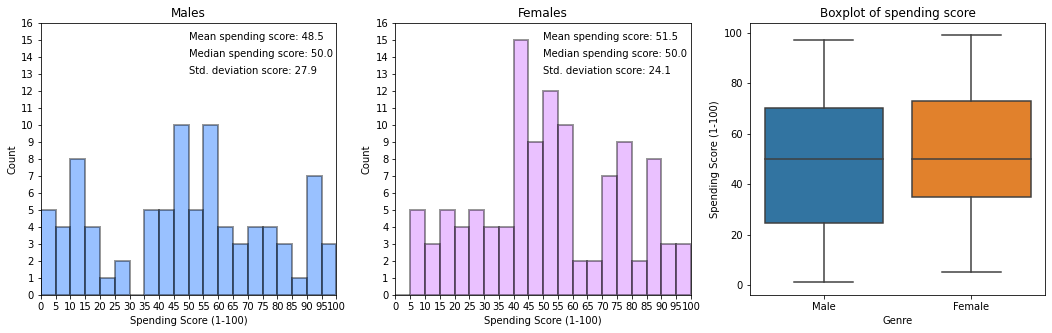

In [10]:
males_spending = mall_data[mall_data['Genre']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Genre']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Genre', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

A mean spending score for women (51.5) is higher than men (48.5).


<a id='Clustering'></a>
## 4. Clustering<a href='#Top' style="text-decoration: none;">^</a><br>  

This section of the notebook describes and demonstrates how to use three clustering algorithms:  
* K-Means
* Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

<a id='K-Means'></a>
### 4.1 K-Means<a href='#Top' style="text-decoration: none;">^</a><br>  

This chapter focuses on a very popular K-Means algorithm being taught in most machine learning courses. The chapter we discuss about a use case (mall customers segmentation).

<a id='K-Means_use_case'></a>
### 4.1.1 Use case - customers segmentation<a href='#Top' style="text-decoration: none;">^</a><br>  

The very first step in a clustering analysis is importing K-Means from the sklearn library.

In [12]:
from sklearn.cluster import KMeans 

For clustering only numeric columns are used. As mentioned at the beginning the binary variable `gender` will not be used here.

In [13]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

In order to find an appropriate number of clusters, the elbow method will be used. In this method for this case, the inertia for a number of clusters between 2 and 10 will be calculated. The rule is to choose the number of clusters where you see a kink or "an elbow" in the graph.

In [22]:
!pip install yellowbrick

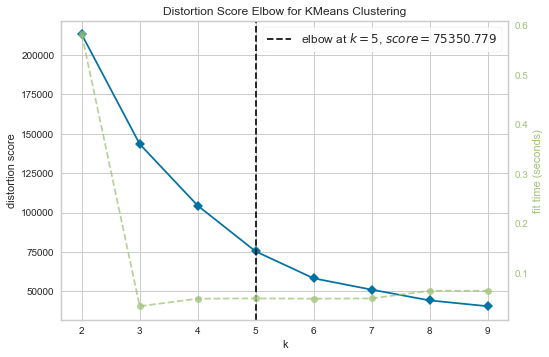

In [15]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

The graph above shows the reduction of a distortion score as the number of clusters increases. However, there is no clear "elbow" visible. The underlying algorithm suggests 5 clusters. A choice of 5 or 6 clusters seems to be fair.

<u>**5 CLUSTERS**</u>

In [16]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

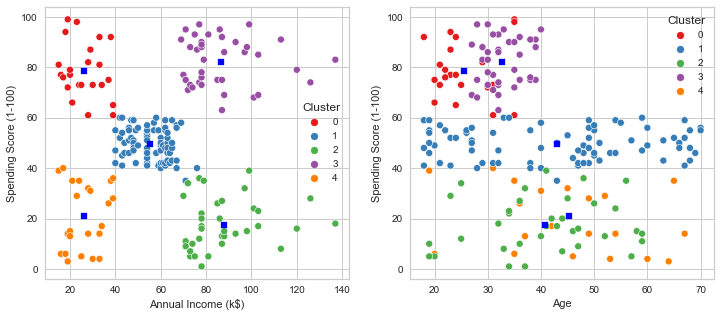

In [24]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means algorithm generated the following 5 clusters:
* clients with **low** annual income and **high** spending score
* clients with **medium** annual income and **medium** spending score
* clients with **high** annual income and **low** spending score
* clients with **high** annual income and **high** spending score
* clients with **low** annual income and **low** spending score

There are no distinct groups is terms of customers age.

<a id='DBSCAN'></a>
### 4.2 DBSCAN<a href='#Top' style="text-decoration: none;">^</a><br>  

This chapter describes how DBSCAN (Density-Based Spatial Clustering of Applications with Noise) works and shows its implementation to the mall customers segmentation.

<a id='DBSCAN use case'></a>
### 4.2.1 Use case - customers segmentation<a href='#Top' style="text-decoration: none;">^</a><br>  

The first step - importing DBSCAN from sklearn.

In [25]:
from sklearn.cluster import DBSCAN

In DBSCAN there are two major hyperparameters:
* `eps`
* `min_samples`

It is difficult arbitrarily to say what values will work the best. Therefore, I will first create a matrix of investigated combinations.

<u>MinPoints:</u> We can obtain the minimum number of Points to be used to recognize a cluster, as follows:
- If the dataset has two dimensions, use the min sample per cluster as 4.
- If the data has more than two dimensions, the min sample per cluster should be: Min_sample(MinPoints) = 2 * Data dimension
- Since our data is two-dimensional, we shall use the default value of 4 as our MinPoint parameter.

<u>Epsilon (Eps):</u> To calculate the value of Eps, we shall calculate the distance between each data point to its closest neighbor using the Nearest Neighbours. After that, we sort them and finally plot them. From the plot, we identify the maximum value at the curvature of the graph. This value is our Eps.

In [32]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X_numerics) # fitting the data to the object
distances,indices=nbrs.kneighbors(X_numerics)

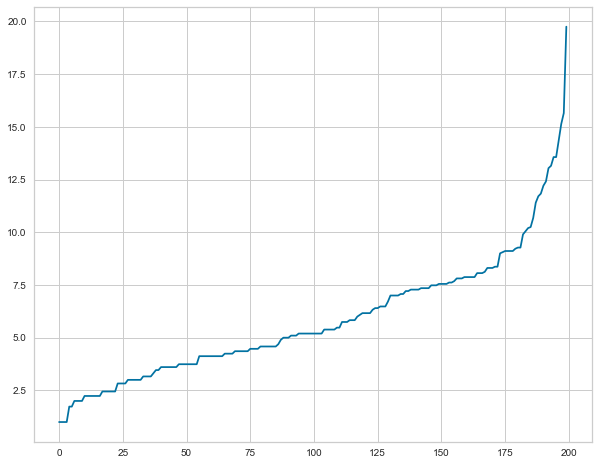

In [33]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (10,8) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

`eps`=12.5 and `min_samples`=6.

In [42]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=6).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

Checking sizes of clusters.

In [43]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,40
0,105
1,6
2,32
3,17


DBSCAN created 5 clusters plus outliers cluster (-1). Sizes of clusters 0-4 vary significantly - some have only 4 or 8 observations. There are 18 outliers.

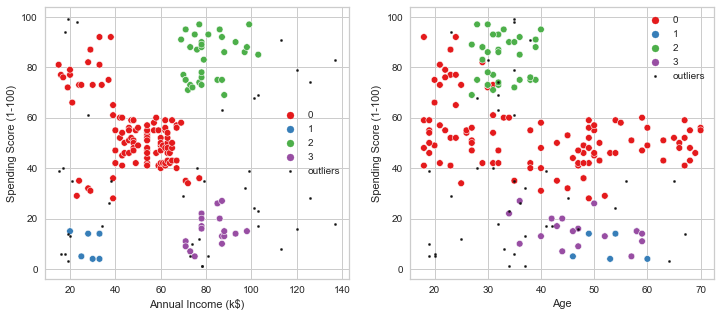

In [44]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

The graph above shows that there are some outliers - these points do not meet distance and minimum samples requirements to be recognised as a cluster.

<a id='References'></a>
## References <a href='#Top' style="text-decoration: none;">^</a><br> 

- https://www.section.io/engineering-education/dbscan-clustering-in-python/
- https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap
- https://medium.com/analytics-vidhya/k-means-clustering-with-python-beginner-tutorial-45a44c34e7f

# Good Job